# COGS 108 - EDA Checkpoint

# Names

- Naomi Chin
- Leo Friedman
- Jake Heinlein
- Dante Tanjuatco
- Nathan Tripp

<a id='research_question'></a>
# Research Question

*Is the combination of an mlb free agents age and batting performance, measured by batting average and on base plus slugging percentage, indicative of their yearly salary, and if so, can an algorithm predict a players future contract based on these factors?*

# Setup

In [86]:
# import packages and setup visuals
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm
import statistics

# Data Cleaning

Describe your data cleaning steps here.

In [2]:
# merge all contract files in contracts directory as one dataframe
directory = 'data/contracts/'
filepaths = [directory + filename for filename in os.listdir(directory)]
contracts = pd.concat([pd.read_csv(filepath) for filepath in filepaths])
contracts_original = contracts
print('contracts shape: ', contracts.shape)

contracts shape:  (4996, 18)


In [3]:
# set 'Age' column to value in 'Age  7/1/21' column or 'Age 7/1/22' column if NaN
contracts['Age'] = contracts['Age'].add(contracts['Age 7/1/21'], fill_value=0)
contracts['Age'] = contracts['Age'].add(contracts['Age 7/1/22'], fill_value=0)

In [4]:
# drop unecessary columns
contracts = contracts[['Player','Pos\'n', 'Age', 'Term', 'AAV']]

# drop players that are pitchers
contracts = contracts[contracts["Pos'n"].str.contains("hp") == False]

# drop players with NaN values
contracts = contracts.dropna(axis=0)

# drop position column (no longer needed)
contracts = contracts.drop('Pos\'n',axis=1)
display(contracts)

,Player,Age,Term,AAV
0,"Strawberry, Darryl",29.000,1991-96,"$4,050,000"
2,"McGee, Willie",32.000,1991-94,"$3,250,000"
5,"Coleman, Vince",29.000,1991-94,"$2,987,500"
8,"Pendleton, Terry",30.000,1991-94,"$2,550,000"
11,"Bell, George",31.000,1991-93,"$3,266,666"
...,...,...,...,...
140,"Parra, Gerardo",34.055,2022,$1
144,"Pillar, Kevin",33.178,2022,$1
147,"Romine, Austin",33.221,2022,$1
148,"Shaw, Travis",32.076,2022,$1


In [5]:
# functions to standardize variables
def salary_to_int(str_in):
    return int(str_in.replace('$','').replace(',',''))

def term_to_year(str_in):
    return int(str(str_in).split('-')[0])

def standardize_name(str_in):
    if ',' in str_in:
        name_list = str(str_in).split(',')
        str_in = name_list[1].strip() + " " + name_list[0].strip()
    str_in = str_in.replace('Jr.','')
    str_in = str_in.replace('Sr.','')
    str_in = str_in.replace('.','')
    str_in = str_in.replace('é','e')
    str_in = str_in.replace('á','a')
    return str_in.replace(' ', '')

def standardize_age(age):
    return round(float(age), 0)

In [6]:
# standardize salary and term variables
contracts['Player'] = contracts['Player'].apply(standardize_name)
contracts['Age'] = contracts['Age'].apply(standardize_age)
contracts['AAV'] = contracts['AAV'].apply(salary_to_int)
contracts['Term'] = contracts['Term'].apply(term_to_year)
contracts

,Player,Age,Term,AAV
0,DarrylStrawberry,29.0,1991,4050000
2,WillieMcGee,32.0,1991,3250000
5,VinceColeman,29.0,1991,2987500
8,TerryPendleton,30.0,1991,2550000
11,GeorgeBell,31.0,1991,3266666
...,...,...,...,...
140,GerardoParra,34.0,2022,1
144,KevinPillar,33.0,2022,1
147,AustinRomine,33.0,2022,1
148,TravisShaw,32.0,2022,1


In [7]:
# rename columns for consistency
contracts.columns = ['playerName','playerAge','year','yearSalary']
contracts.head()

,playerName,playerAge,year,yearSalary
0,DarrylStrawberry,29.0,1991,4050000
2,WillieMcGee,32.0,1991,3250000
5,VinceColeman,29.0,1991,2987500
8,TerryPendleton,30.0,1991,2550000
11,GeorgeBell,31.0,1991,3266666


In [8]:
# read people and batting files as dataframes
people = pd.read_csv('data/batting/People.csv')
batting = pd.read_csv('data/batting/Batting.csv')
batting_original = batting
print('people shape: ', people.shape)
print('batting shape: ', batting.shape)

people shape:  (20370, 24)
batting shape:  (110495, 22)


In [9]:
batting = batting[['playerID', 'yearID', 'AB', 'H', '2B', '3B', 'HR', 'BB','HBP','SF']]

In [10]:
display(batting[batting['playerID'] == 'abramca01'])
batting = batting.groupby(['playerID', 'yearID']).agg(lambda x: x.sum(min_count=1))
batting = batting.reset_index()
display(batting[batting['playerID'] == 'abramca01'])

,playerID,yearID,AB,H,2B,3B,HR,BB,HBP,SF
33904,abramca01,1949,24,2,1,0,0,7,0.0,NaN
34477,abramca01,1950,44,9,1,0,0,9,0.0,NaN
35053,abramca01,1951,150,42,8,0,3,36,0.0,NaN
35670,abramca01,1952,10,2,0,0,0,2,0.0,NaN
35671,abramca01,1952,158,44,9,2,2,19,0.0,NaN
36303,abramca01,1953,448,128,10,6,15,58,0.0,NaN
36889,abramca01,1954,42,6,1,1,0,10,0.0,0.0
36890,abramca01,1954,423,124,22,7,6,72,4.0,1.0
37466,abramca01,1955,309,75,12,3,6,89,3.0,3.0
38121,abramca01,1956,3,1,0,0,0,2,0.0,0.0


,playerID,yearID,AB,H,2B,3B,HR,BB,HBP,SF
187,abramca01,1949,24,2,1,0,0,7,0.0,NaN
188,abramca01,1950,44,9,1,0,0,9,0.0,NaN
189,abramca01,1951,150,42,8,0,3,36,0.0,NaN
190,abramca01,1952,168,46,9,2,2,21,0.0,NaN
191,abramca01,1953,448,128,10,6,15,58,0.0,NaN
192,abramca01,1954,465,130,23,8,6,82,4.0,1.0
193,abramca01,1955,309,75,12,3,6,89,3.0,3.0
194,abramca01,1956,3,1,0,0,0,2,0.0,0.0


In [11]:
# drop observations with NaN values
batting = batting.dropna(axis=0)

# drop observations with 0 At Bats
batting = batting[batting['AB'] > 0]
batting.shape

(53054, 10)

In [12]:
# functions used for calculating batting average and OBS average
def calc_avg(h, ab):
    return h / ab
    
def calc_obp(h, bb, hbp, ab, sf):
    return (h + bb + hbp) / (ab + bb + sf + hbp)
    
def calc_tb(h, two_b, three_b, hr):
    singles = h - two_b - three_b - hr
    return singles + two_b * 2 + three_b * 3 + hr * 4

def calc_slg(tb, ab):
    return tb / ab

def calc_obs(obp, slg):
    return obp + slg

In [13]:
# create Batting Average column in batting dataframe
avg = calc_avg(h=batting['H'], ab=batting['AB'])
batting['AVG'] = round(avg, 3)

# create On Base Percentage average column in batting dataframe
obp = calc_obp(h=batting['H'], bb=batting['BB'], hbp=batting['HBP'], ab=batting['AB'], sf=batting['SF'])
batting['OBP'] = round(obp, 3)

# create Slugging average column in batting dataframe
tb = calc_tb(h=batting['H'], two_b=batting['2B'], three_b=batting['3B'], hr=batting['HR'])
slg = calc_slg(tb, batting['AB'])
batting['SLG'] = round(slg, 3)

# create On Base Plus Slugging column in batting dataframe
obs = calc_obs(obp, slg)
batting['OBS'] = round(obs, 3)

batting.head()

,playerID,yearID,AB,H,2B,3B,HR,BB,HBP,SF,AVG,OBP,SLG,OBS
1,aardsda01,2006,2,0,0,0,0,0,0.0,0.0,0.000,0.000,0.000,0.000
3,aardsda01,2008,1,0,0,0,0,0,0.0,0.0,0.000,0.000,0.000,0.000
8,aardsda01,2015,1,0,0,0,0,0,0.0,0.0,0.000,0.000,0.000,0.000
9,aaronha01,1954,468,131,27,6,13,28,3.0,4.0,0.280,0.322,0.447,0.769
10,aaronha01,1955,602,189,37,9,27,49,3.0,4.0,0.314,0.366,0.540,0.906


In [14]:
# drop irrelevant columns and rename
batting = batting[['playerID', 'yearID','AB', 'AVG', 'OBP','SLG','OBS']]
batting.columns = ['playerID', 'year', 'AB', 'AVG', 'OBP', 'SLG','OBS']

In [15]:
# add name column to people that combines players first and last name
people['name'] = people['nameFirst'] + ' ' + people['nameLast']

# drop irrelevant columns
people = people[['playerID','name']]

# merge batting and people to add name column to batting dataframe
batting = batting.merge(people, how='left', on='playerID')

# rename and reorder  batting columns for consistency 
batting = batting.rename({'name':'playerName'}, axis=1)
batting = batting[['playerID','playerName','year','AB', 'AVG', 'OBP', 'SLG','OBS']]

# standardize playerName column
batting['playerName'] = batting['playerName'].apply(standardize_name)
batting.head()

,playerID,playerName,year,AB,AVG,OBP,SLG,OBS
0,aardsda01,DavidAardsma,2006,2,0.000,0.000,0.000,0.000
1,aardsda01,DavidAardsma,2008,1,0.000,0.000,0.000,0.000
2,aardsda01,DavidAardsma,2015,1,0.000,0.000,0.000,0.000
3,aaronha01,HankAaron,1954,468,0.280,0.322,0.447,0.769
4,aaronha01,HankAaron,1955,602,0.314,0.366,0.540,0.906


In [16]:
# remove players from batting who are not in contracts
batting = batting[batting['playerName'].isin(list(contracts['playerName'].unique()))]

# NOTE: 22 names in contracts missing from batting; Caused by naming disparities in databases;
print('number of missing names from batting: ', len(contracts['playerName'].unique()) - len(batting['playerName'].unique()))
print('batting: ', batting.shape)
print('cotracts: ', contracts.shape)

number of missing names from batting:  22
batting:  (10324, 8)
cotracts:  (1524, 4)


In [17]:
print(len(contracts['playerName'].unique()))
print(len(batting['playerName'].unique()))

799
777


In [24]:
# all names associated with a unique playerID
names = pd.Series([group[1]['playerName'].reset_index(drop=True)[0] for group in batting.groupby('playerID')])
name_counts = names.value_counts();

# list of players with the same name 
repeated_names = list(name_counts[name_counts > 1].index)

# remove batters and contracts with this name, I wish we didn't have to do this...
batting = batting[~batting['playerName'].isin(repeated_names)]
contracts = contracts[~contracts['playerName'].isin(repeated_names)]

In [25]:
# results of cleaning: 
print('original contracts dataframe: ')
print('\tshape: ', contracts_original.shape)
print('\tunique players: ', len(list(contracts_original['Player'].unique())))

print('new contracts dataframe: ')
print('\tshape: ', contracts.shape)
print('\tunique players: ', len(list(contracts['playerName'].unique())),'\n')

print('original batting dataframe: ')
print('\tshape: ', batting_original.shape)
print('\tunique players: ', len(list(batting_original['playerID'].unique())))

print('new batting dataframe: ')
print('\tshape: ', batting.shape)
print('\tunique players: ', len(list(batting['playerName'].unique())))

original contracts dataframe: 
	shape:  (4996, 18)
	unique players:  2050
new contracts dataframe: 
	shape:  (1436, 4)
	unique players:  761 

original batting dataframe: 
	shape:  (110495, 22)
	unique players:  20166
new batting dataframe: 
	shape:  (9493, 8)
	unique players:  739


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

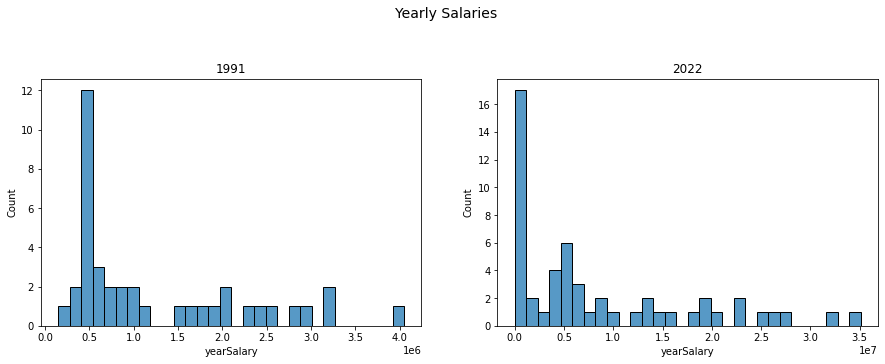

In [43]:
## YOUR CODE HERE

# compare yearly salaries between 1991 and 2022
fig = plt.figure(figsize=(15, 10))
plt.suptitle("Yearly Salaries", fontsize=14)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.title.set_text('1991')
ax2.title.set_text('2022')
sns.histplot(data = contracts[contracts['year'] == 1991], x = 'yearSalary', bins = 30, ax = ax1)
sns.histplot(data = contracts[contracts['year'] == 2022], x = 'yearSalary', bins = 30, ax = ax2)
plt.show()

C:\Users\naomi\AppData\Local\Temp/ipykernel_17780/3316214618.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_years['avg salary'][i] = statistics.mean(contracts[contracts['year'] == salary_years['year'][i]]['yearSalary'])


<AxesSubplot:xlabel='year', ylabel='avg salary'>

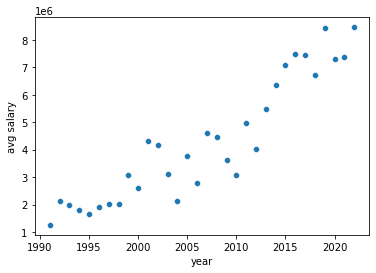

In [104]:
# compare average salaries over the years

salary_years = contracts['year'].value_counts().rename_axis('year').reset_index(name='counts')
salary_years['avg salary'] = ''
for i in range(len(salary_years)):
    salary_years['avg salary'][i] = statistics.mean(contracts[contracts['year'] == salary_years['year'][i]]['yearSalary'])

salary_years = salary_years.sort_values(by=['year'])

sns.scatterplot(data=salary_years, x='year', y='avg salary')

# try to fit the data (linear/exponential/etc)